In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

In [29]:
# processor = AutoProcessor.from_pretrained("tensorspeech/tts-fastspeech2-ljspeech-en")
processor = AutoProcessor.from_pretrained(
    pretrained_path="../tensorflow_tts/processor/pretrained/libritts_mapper.json"
)
processor.mode = 'inference'
processor.mode 


'inference'

In [27]:
# processor.text_to_sequence("i love you")
from g2p_en import g2p as grapheme_to_phonem
g2p = grapheme_to_phonem.G2p()
input_ids = processor.symbols_to_ids(processor.clean_g2p(g2p("i love you")))

In [80]:
input_text = "i love you so much"
input_ids = processor.text_to_sequence(input_text)


In [42]:
# fastspeech2 = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech2-ljspeech-en")
config_path = "../ttsexamples/fastspeech2_libritts/conf/fastspeech2libritts.yaml"
config = AutoConfig.from_pretrained(pretrained_path=config_path)
fastspeech2 = TFAutoModel.from_pretrained(
    pretrained_path="../ttsexamples/fastspeech2_libritts/outdir_libri/checkpoints/model-150000.h5",
    config=config)


# Save to Pb

In [43]:
# save model into pb and do inference. Note that signatures should be a tf.function with input_signatures.
tf.saved_model.save(fastspeech2, "./test_saved", signatures=fastspeech2.inference)

INFO:tensorflow:Assets written to: ./test_saved/assets


INFO:tensorflow:Assets written to: ./test_saved/assets


# Load and Inference

In [44]:
fastspeech2 = tf.saved_model.load("./test_saved")

In [51]:
input_text = "There’s a way to measure the acute emotional intelligence that has never gone out of style"
input_ids = processor.text_to_sequence(input_text)


In [81]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

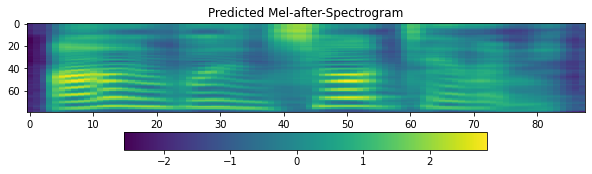

In [82]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

# Let inference other input to check dynamic shape

In [119]:
input_text = "The Commission further recommends that the Secret Service coordinate its planning as closely as possible with all of the Federal agencies from which it receives information"
input_ids = processor.text_to_sequence(input_text)

In [120]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

In [116]:
## test
# with open('../pretrained/mbvocs24k/multiband_melgan.v1_24k.yaml') as f:
#     config = yaml.load(f, Loader=yaml.Loader)


config = AutoConfig.from_pretrained('../pretrained/mbvocs24k/multiband_melgan.v1_24k.yaml')
mb_melgan = TFAutoModel.from_pretrained(
    config=config, 
    pretrained_path=None,
    name="mb_melgan"
)
mb_melgan.load_weights('../pretrained/mbvocs24k/libritts_24k.h5')




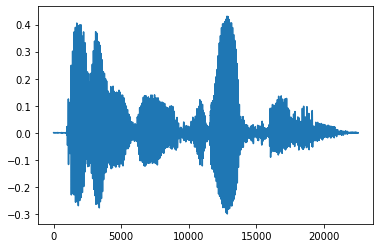

In [124]:
mb_melgan.inference(mel_before)
plt.plot(audios[0, :, 0])


import soundfile as sf
# sf.write('out.wav', y, 24000, 'PCM_24')
sf.write('out.wav', audios[0, :, 0], 24000, "PCM_16")



In [109]:
# import soundfile as sf
# sf.write('before.wav', wavs[0], 16000, "PCM_16")
# sf.write('after.wav', wavs[1], 16000, "PCM_16")


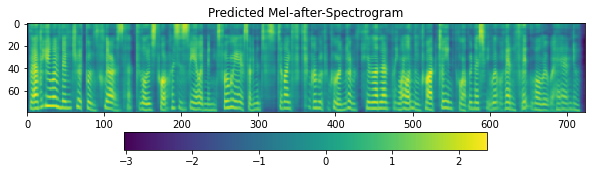

In [57]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

((88, 80), TensorShape([1, 88, 80]))

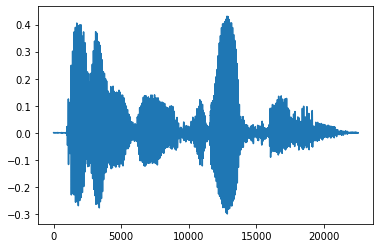

In [84]:
# mels = np.load("../dump_libritts/valid/norm-feats/LJ001-0009-norm-feats.npy")
mels = np.load('../dump_libritts/valid/norm-feats/1743_142912_000003_000001-norm-feats.npy')
audios = mb_melgan.inference(mel_after[None, ...])
y = audios[0, :, 0]
plt.plot(audios[0, :, 0])

# import IPython.display as ipd
# ipd.Audio(audios[0, :, 0], rate=24000) # load a NumPy array


import soundfile as sf
# sf.write('out.wav', y, 24000, 'PCM_24')
sf.write('out.wav', y, 22050, "PCM_16")


In [67]:
# mels.shape, mel_after.shape

((329, 80), (724, 80))